In [1]:
partisan_dimen = "partisan"
political_activity_category = "all"

In [8]:
import sys
import os
sys.path.append("..")
from commembed.jupyter import *
import commembed.linalg as linalg
import commembed.dimens as dimens
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from pyspark.sql.functions import *

import commembed.data as data


spark = data.spark_context()

%load_ext autoreload
%autoreload 2

Spark WebUI: http://ada.ais.sandbox:4047


In [ ]:
all_objects = data.load("all_objects")
spark.sql("""
    select author, subreddit, from_unixtime(created_utc, 'yyyy-MM') as month, count(*) as num_comments
    from all_objects
    where id like 't1_%'
    group by 1, 2, 3
""").write.parquet(data.DATA_PATH + "/all_objects_monthly_user_counts.parquet")

In [ ]:
data.load("all_objects_monthly_user_counts")
spark.sql("""select author, subreddit, sum(num_comments) as num_comments
          from all_objects_monthly_user_counts group by 1, 2""") \
        .write.parquet(data.DATA_PATH + "/all_objects_user_counts.parquet")

# Finding partisan-ness cutoff

0.5125628140703518
553 subs (5.53%)


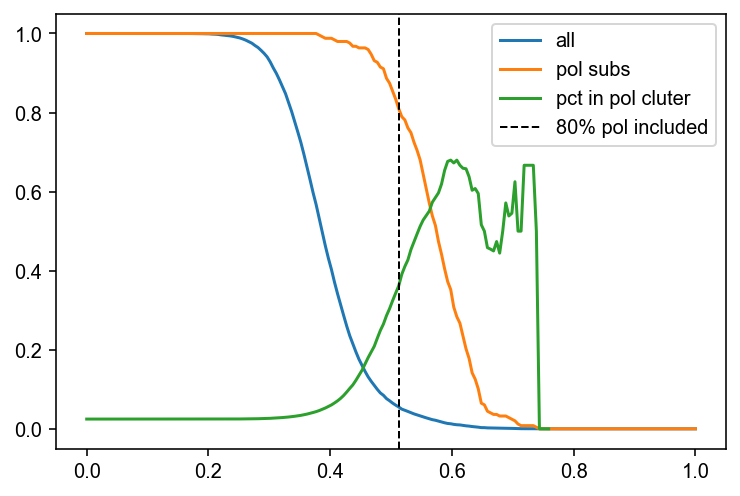

In [7]:
embedding = load_embedding('reddit', 'master')
dimen_list = dimens.load_dimen_list('final')
scores = dimens.score_embedding(embedding, dimen_list)
scores_orig = scores

partisan_dimen = "partisan"

# Create filtered scores for subreddits that are political.
# Choose a cutoff on partisan_neutral that covers 80% of subreddits in the political cluster from
# our manually labelled clustering
clustering = load_clustering("reddit_all_numbered")
clustering = clustering[clustering["cluster_name"] == "Politics"]
plt.figure()

x = np.linspace(0, 1, 200)
y_clustering = []
y_all = []
y_pct_in_pol_cluster = []
for cutoff in x:
    rows = scores_orig[scores_orig[partisan_dimen+"_neutral"] > cutoff]
    y_clustering.append(len(rows.join(clustering, how='inner')))
    y_all.append(len(rows))
    y_pct_in_pol_cluster.append(y_clustering[-1]/y_all[-1] if y_all[-1] > 0 else np.nan)
plt.plot(x, np.array(y_all) / len(scores_orig), label="all")
plt.plot(x, np.array(y_clustering) / len(clustering), label="pol subs")
plt.plot(x, np.array(y_pct_in_pol_cluster), label="pct in pol cluter")

target_pct = 0.80
target_x = x[((np.array(y_clustering)/len(clustering)) > target_pct).nonzero()[0][-1]]

print(target_x)
print("%d subs (%.2f%%)" % (np.sum(scores_orig[partisan_dimen+"_neutral"] > target_x), 100*np.mean(scores_orig[partisan_dimen+"_neutral"] > target_x)))
plt.axvline(target_x, label='%.0f%% pol included' % (target_pct*100), color='black', linestyle='--', linewidth=1)

plt.legend()
plt.show()

In [3]:
user_counts = data.load("all_objects_monthly_user_counts")
user_counts.createOrReplaceTempView("user_counts")
user_counts.createOrReplaceTempView("monthly_user_counts")

scores, scores_df = load_politics_z_df(partisan_dimen, political_activity_category)

(Freshly loading table all_objects_monthly_user_counts)
Spark WebUI: http://ada.ais.sandbox:4043
553 political subreddits selected


In [4]:
filtered_counts = spark.sql("select * from user_counts inner join scores on subreddit = community")
filtered_counts.createOrReplaceTempView("filtered_counts")

In [5]:
author_first_months = filtered_counts.groupBy("author").agg(min("month").alias("first_month"))
author_first_months.cache()
author_first_months.createOrReplaceTempView("author_first_months")

In [6]:
months = ["%04d-%02d" % (y,m) for y in range(2000,2030) for m in range(1, 13)]

rows = []
for i, month1 in enumerate(months):
    for j, month2 in enumerate(months):
        rows.append([month1, month2, j-i])

month_offset = 12
next_months = pd.DataFrame(rows, columns=["month_0", "month_1", "month_offset"])

spark.createDataFrame(next_months).createOrReplaceTempView("next_months")
next_months.head(12)

,month_0,month_1,month_offset
0,2000-01,2000-01,0
1,2000-01,2000-02,1
2,2000-01,2000-03,2
3,2000-01,2000-04,3
4,2000-01,2000-05,4
5,2000-01,2000-06,5
6,2000-01,2000-07,6
7,2000-01,2000-08,7
8,2000-01,2000-09,8
9,2000-01,2000-10,9


In [7]:
user_month_activity = spark.sql("""

    select month_activity_1.author, month as calendar_month,
        month_offset as month_since_join_index,
        (rank() over (partition by month_activity_1.author order by month asc))-1 as active_month_index,
        num_comments, avg_z_score, avg_abs_z_score
        
    from (
    select author, month, sum(num_comments) as num_comments,
        sum(num_comments * partisan_dimen)/sum(num_comments) as avg_z_score,
        sum(num_comments * abs(partisan_dimen))/sum(num_comments) as avg_abs_z_score
    
    from filtered_counts
    
    group by 1, 2
    ) month_activity_1
    
    left join author_first_months
    on author_first_months.author = month_activity_1.author
    
    inner join next_months
    on month_0 = author_first_months.first_month and month_1 = month
    
    order by 1, 2
    
""")

In [9]:
# Save
user_month_activity.write.parquet(
    os.path.join(data.DATA_PATH, "user_partisan_scores_%s_%s.parquet" % (partisan_dimen, political_activity_category)))

-----

# Additional political activity data

In [ ]:
monthly_partisan_stats = spark.sql(f"""

    select author, month,
        count(*) as num_subreddits,
        sum(num_comments) as num_comments,
        sum({partisan_dimen}*num_comments)/sum(num_comments) as mean
    
    from monthly_user_counts
    
    inner join scores
    on scores.community = subreddit
    
    where author != "[deleted]"
    
    group by author, month
    order by num_subreddits desc

""")

monthly_partisan_stats.write.parquet(data.DATA_PATH+"/monthly_"+partisan_dimen+"_stats.parquet")

In [ ]:
partisan_mean = np.mean(scores[partisan_dimen])
partisan_std = np.std(scores[partisan_dimen])

monthly_partisan_stats = spark.read.parquet(data.DATA_PATH+f"/monthly_{partisan_dimen}_stats.parquet")
monthly_partisan_stats.createOrReplaceTempView("monthly_partisan_stats")
user_bins = spark.sql(f"""
    select author, month,
        case
            when mean < {partisan_mean - partisan_std} then 1
            when mean > {partisan_mean + partisan_std} then 4
            --when sqrt(variance) < {partisan_std} then 2
            else 3
        end as user_bin
    
    
    from monthly_partisan_stats
""")
user_bins.cache()
user_bins.show()

In [ ]:
user_bins.createOrReplaceTempView("user_bins")
monthly_user_count_backfill_data = spark.sql("""
    select subreddit, monthly_user_counts.author, monthly_user_counts.month as month,
        first(last_months.last_month) as target_month,
        max(user_bins.month) as latest_month_with_data
    
    from (
        select monthly_user_counts.* from monthly_user_counts
        inner join scores
        on scores.community = subreddit
    ) monthly_user_counts
    
    inner join last_months
    on last_months.month = monthly_user_counts.month
    
    inner join user_bins
    on user_bins.author = monthly_user_counts.author and user_bins.month <= last_months.last_month

    group by 1, 2, 3
""")
monthly_user_count_backfill_data.cache()
monthly_user_count_backfill_data.show()

In [ ]:
user_bins.createOrReplaceTempView("user_bins")
monthly_user_count_backfill_data.createOrReplaceTempView("monthly_user_count_backfill_data")


activity_data_df = spark.sql("""

    select monthly_user_counts.subreddit,
        monthly_user_counts.month,
        coalesce(user_bins.user_bin, 5) as last_month_user_bin,
        sum(num_comments) as num_comments
    
    from monthly_user_counts
    
    -- prunes records that are not in embedding
    inner join scores
    on scores.community = subreddit
    
    -- prunes records that are not in month of interest
    inner join last_months
    on last_months.month = monthly_user_counts.month
    
    -- need to keep all records, for new newly political users
    left join monthly_user_count_backfill_data
    on monthly_user_count_backfill_data.subreddit = monthly_user_counts.subreddit
        and monthly_user_count_backfill_data.author = monthly_user_counts.author
        and monthly_user_count_backfill_data.month = monthly_user_counts.month
    
    -- need to keep all records, for new newly political users
    left join user_bins
    on user_bins.author = monthly_user_counts.author
        and user_bins.month = monthly_user_count_backfill_data.latest_month_with_data
    
    where monthly_user_counts.author != '[deleted]'
    
    group by 1, 2, 3

""")
activity_data_df.cache()

In [ ]:
activity_data_df.write.parquet(data.DATA_PATH+f"/{partisan_dimen}_activity_data_12mo.parquet")